In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
print("All libraries imported successfully")


All libraries imported successfully


In [2]:
# --- 1. Defining Constants for Ethanol(1) - Water(2) System ---

# Set total pressure in kPa
P_total_kPa = 101.325

# Antoine Equation parameters for P_sat in kPa and T in Celsius
# log10(P_sat) = A - B / (T + C)
antoine_params = {
    'ethanol': {'A': 7.24438, 'B': 1598.673, 'C': 226.184},
    'water':   {'A': 7.19621, 'B': 1730.63, 'C': 233.426}
}

# Wilson model interaction parameters (unitless)
# These are literature values for the Ethanol-Water system
wilson_params = {
    'A12': 0.2855,
    'A21': 1.5583
}

print("Libraries imported and constants defined successfully!")

Libraries imported and constants defined successfully!


In [3]:
# --- 2. Defining Thermodynamic Calculation Functions ---

def get_antoine_pressure(T_celsius, component_params):
    """Calculates saturation pressure using the Antoine equation."""
    A = component_params['A']
    B = component_params['B']
    C = component_params['C']
    P_sat_log10 = A - (B / (T_celsius + C))
    return 10**P_sat_log10

def get_activity_coeffs(x1, wilson_params):
    """Calculates activity coefficients using the Wilson model."""
    x2 = 1.0 - x1
    A12 = wilson_params['A12']
    A21 = wilson_params['A21']
    
    # Avoid division by zero at endpoints
    if x1 == 0: return (10e5, 1.0) # Arbitrarily large gamma1 to prevent issues
    if x2 == 0: return (1.0, 10e5)

    ln_gamma1 = -np.log(x1 + A12 * x2) + x2 * ((A12 / (x1 + A12 * x2)) - (A21 / (A21 * x1 + x2)))
    ln_gamma2 = -np.log(x2 + A21 * x1) + x1 * ((A21 / (x2 + A21 * x1)) - (A12 / (A12 * x2 + x1)))
    
    return np.exp(ln_gamma1), np.exp(ln_gamma2)

print("Thermodynamic functions are ready.")

Thermodynamic functions are ready.


In [ ]:
# --- 3. Bubble Point Calculation and Data Generation ---

def calculate_bubble_point(x1, T_guess=80):
    """
    For a given liquid composition x1 and total pressure, this function calculates
    the bubble point temperature (T) and vapor composition (y1).
    """
    def objective_function(T):
        gamma1, gamma2 = get_activity_coeffs(x1, wilson_params)
        P1_sat = get_antoine_pressure(T, antoine_params['ethanol'])
        P2_sat = get_antoine_pressure(T, antoine_params['water'])
        
        # Modified Raoult's Law: Sum of partial pressures must equal total pressure
        return x1 * gamma1 * P1_sat + (1 - x1) * gamma2 * P2_sat - P_total_kPa

    # Using a numerical solver to find the temperature T that satisfies the objective function
    T_bubble, = fsolve(objective_function, T_guess)
    
    # Now, calculating y1 at the solved bubble point temperature
    gamma1, _ = get_activity_coeffs(x1, wilson_params)
    P1_sat = get_antoine_pressure(T_bubble, antoine_params['ethanol'])
    y1 = (x1 * gamma1 * P1_sat) / P_total_kPa
    
    return T_bubble, y1

# --- Generating the dataset ---
# Create a wide, coarse grid of x1 values
x1_coarse = np.linspace(0.0, 1.0, 200)

# Create a dense grid near the azeotrope (~0.8-0.95 for ethanol-water) 
x1_dense = np.linspace(0.8, 0.95, 200)

# Combining and removing duplicates
x1_values = np.unique(np.concatenate([x1_coarse, x1_dense]))

# Generating data points
vle_data = []
for x1 in x1_values:
    T, y1 = calculate_bubble_point(x1)
    # Append the tuple (x1, T, P, y1)
    vle_data.append((x1, T, P_total_kPa, y1))

# Creating a Pandas DataFrame
df = pd.DataFrame(vle_data, columns=['x1', 'T', 'P', 'y1'])

print(f"Generated {len(df)} data points.")
df.head()

Generated 391 data points.


,x1,T,P,y1
0,0.000000,99.997024,101.325,0.000000
1,0.005025,99.539657,101.325,0.021183
2,0.010050,99.107740,101.325,0.041023
3,0.015075,98.698989,101.325,0.059659
4,0.020101,98.311376,101.325,0.077213


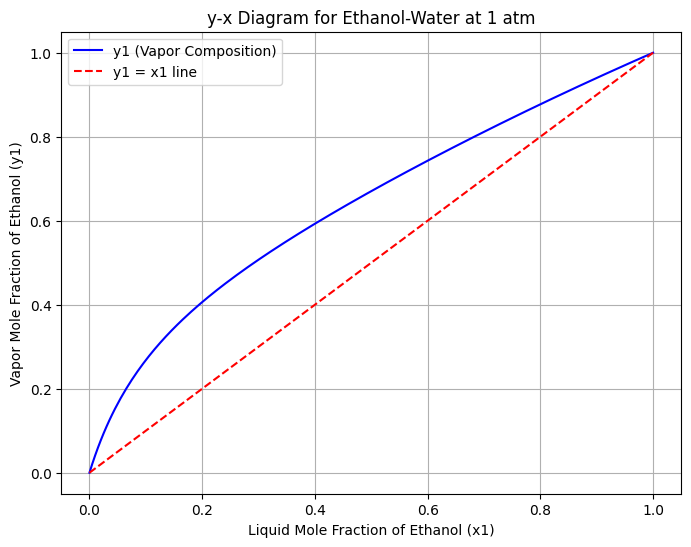

In [5]:
# --- 4. Visualizing the y-x Diagram ---

plt.figure(figsize=(8, 6))
plt.plot(df['x1'], df['y1'], label='y1 (Vapor Composition)', color='blue')
plt.plot([0, 1], [0, 1], 'r--', label='y1 = x1 line')
plt.title('y-x Diagram for Ethanol-Water at 1 atm')
plt.xlabel('Liquid Mole Fraction of Ethanol (x1)')
plt.ylabel('Vapor Mole Fraction of Ethanol (y1)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# --- 1. Define Inputs and Output ---
X = df[['x1', 'T', 'P']]
y = df['y1']

# --- 2. Splitting Data into Training/Validation (80%) and Test (20%) sets ---
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 3. Splitting the Training/Validation set into final Training (80%) and Validation (20%) sets ---
# This results in an overall split of 64% training, 16% validation, 20% testing
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (249, 3)
Validation set shape: (63, 3)
Test set shape: (79, 3)


In [ ]:
# --- 4. Initialize and Fit the Scaler ---
# Creating the scaler object
scaler = MinMaxScaler()

# Fit the scaler ONLY on the training data
scaler.fit(X_train)

# --- 5. Apply the Scaler to All Datasets ---
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Displaying the first 5 rows of the scaled training data to see the result
print("\nFirst 5 rows of scaled training data:")
print(pd.DataFrame(X_train_scaled, columns=X_train.columns).head())


First 5 rows of scaled training data:
         x1         T    P
0  0.900000  0.052822  0.0
1  0.826142  0.093795  0.0
2  0.845939  0.082636  0.0
3  0.836041  0.088199  0.0
4  0.909898  0.047463  0.0



Raoult's Law Baseline RMSE: 0.0435


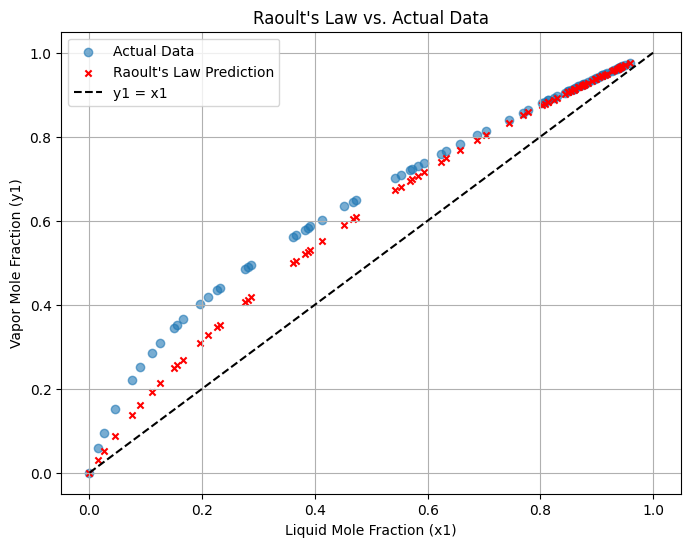

In [ ]:
def raoults_law_y1(x1, T, P_total):
    """Calculates y1 using Raoult's Law (ideal behavior)."""
    p1_sat = get_antoine_pressure(T, antoine_params['ethanol'])
    return (x1 * p1_sat) / P_total

# --- 6. Calculating y1 using Raoult's Law for the test set ---
# Note: We use the original, unscaled test data for this physics-based calculation
y_pred_raoult = raoults_law_y1(X_test['x1'], X_test['T'], X_test['P'])

# --- 7. Calculating the error (RMSE) for the baseline model ---
from sklearn.metrics import mean_squared_error
rmse_raoult = np.sqrt(mean_squared_error(y_test, y_pred_raoult))
print(f"\nRaoult's Law Baseline RMSE: {rmse_raoult:.4f}")

# --- 8. Visualizing the Baseline Performance ---
plt.figure(figsize=(8, 6))
plt.scatter(X_test['x1'], y_test, label='Actual Data', alpha=0.6)
plt.scatter(X_test['x1'], y_pred_raoult, label="Raoult's Law Prediction", color='red', marker='x', s=20)
plt.plot([0, 1], [0, 1], 'k--', label='y1 = x1')
plt.title("Raoult's Law vs. Actual Data")
plt.xlabel("Liquid Mole Fraction (x1)")
plt.ylabel("Vapor Mole Fraction (y1)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# --- 9. Build the Sequential Model ---
model = tf.keras.Sequential([
    # Input Layer: Expects 3 features (x1, T, P)
    tf.keras.layers.Dense(units=32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    
    # Hidden Layer 1
    tf.keras.layers.Dense(units=32, activation='relu'),
    
    # Output Layer: Predicts a single value (y1) between 0 and 1
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# --- 10. Print the model summary ---
model.summary()

c:\Users\Saubhagya\Desktop\ANN Model for binary azeotropic VLE\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,217 (4.75 KB)

 Trainable params: 1,217 (4.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- 11. Compiling the model ---
model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

print("\nModel compiled successfully.")


Model compiled successfully.


In [ ]:
# --- 12. Training the model ---
print("\nStarting model training...")

history = model.fit(
    X_train_scaled, 
    y_train,
    epochs=100,
    # Providing validation data to monitor performance
    validation_data=(X_val_scaled, y_val),
    # Use batch_size to process data in smaller chunks
    batch_size=32,
    # Set verbose=0 to keep the output clean for the final run, 
    # Set it to 1 to see the progress of each epoch.
    verbose=0 
)

print("Model training complete.")


Starting model training...
Model training complete.


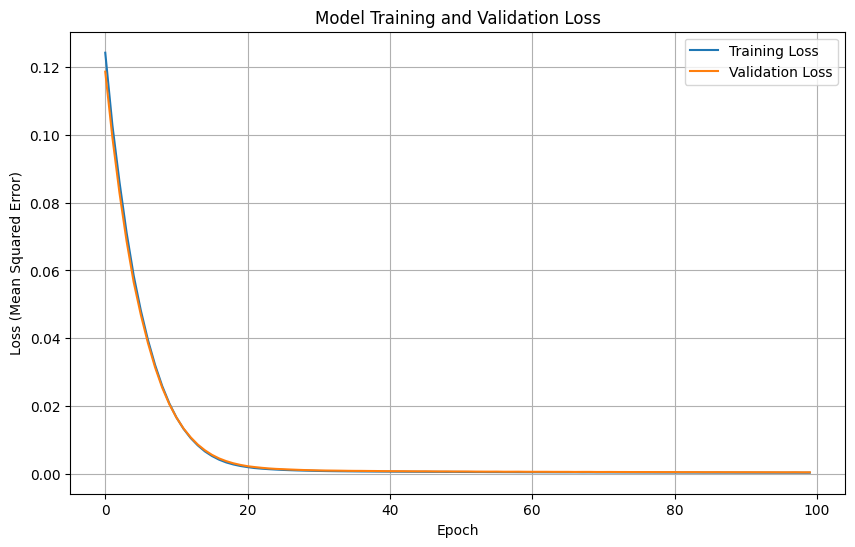

In [ ]:
# --- 13. Plot the learning curves ---
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# --- 14. Evaluating the model on the unseen test set ---
loss = model.evaluate(X_test_scaled, y_test, verbose=0)
rmse_ann = np.sqrt(loss)

print(f"Raoult's Law Baseline RMSE: {rmse_raoult:.4f}")
print(f"Artificial Neural Network RMSE: {rmse_ann:.4f}")
print(f"\nThe ANN model is significantly more accurate than the ideal baseline.")

Raoult's Law Baseline RMSE: 0.0435
Artificial Neural Network RMSE: 0.0264

The ANN model is significantly more accurate than the ideal baseline.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


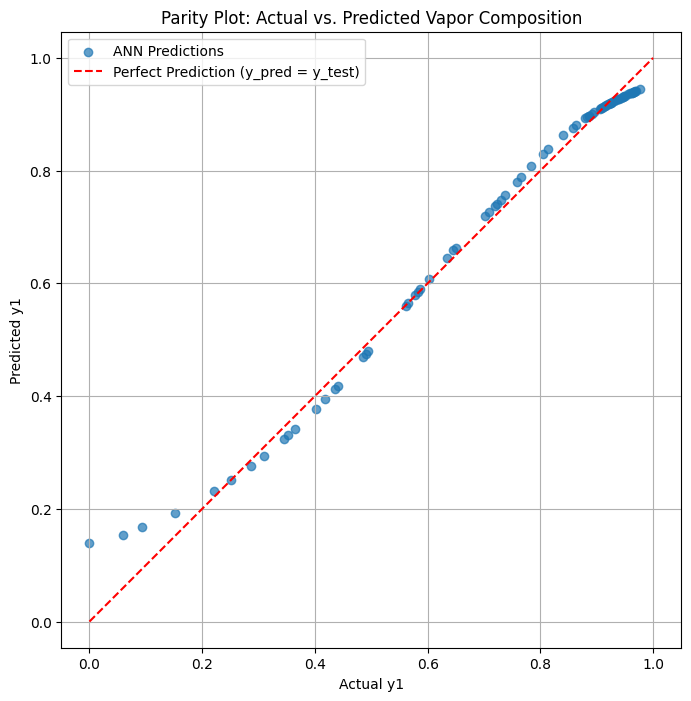

In [ ]:
# --- 15. Making predictions on the test set ---
y_pred_ann = model.predict(X_test_scaled).flatten()

# --- 16. Creating the parity plot ---
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_ann, alpha=0.7, label='ANN Predictions')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Prediction (y_pred = y_test)')
plt.title('Parity Plot: Actual vs. Predicted Vapor Composition')
plt.xlabel('Actual y1')
plt.ylabel('Predicted y1')
plt.legend()
plt.grid(True)
plt.axis('equal') # This ensures the x and y axes have the same scale
plt.show()

In [ ]:
# --- 17. Generating a fine-grained grid of x1 values ---
x1_range = np.linspace(0, 1, 500)
T_range = np.array([calculate_bubble_point(x)[0] for x in x1_range])
P_range = np.full_like(x1_range, P_total_kPa)

# --- 18. Packaging and scaling this new data ---
X_full_range = pd.DataFrame({'x1': x1_range, 'T': T_range, 'P': P_range})
X_full_range_scaled = scaler.transform(X_full_range)

# --- 19. Predict y1 across the full range ---
y1_pred_range = model.predict(X_full_range_scaled).flatten()

# --- 20. Find the azeotrope (where |y1 - x1| is minimum) ---
diff = np.abs(y1_pred_range - x1_range)
azeotrope_idx = np.argmin(diff)
azeotrope_x = x1_range[azeotrope_idx]
azeotrope_T = T_range[azeotrope_idx]

print(f"\n--- Azeotrope Detection ---")
print(f"Predicted Azeotropic Composition (x1): {azeotrope_x:.4f}")
print(f"Predicted Azeotropic Temperature (T): {azeotrope_T:.2f} °C")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

--- Azeotrope Detection ---
Predicted Azeotropic Composition (x1): 0.9399
Predicted Azeotropic Temperature (T): 79.62 °C


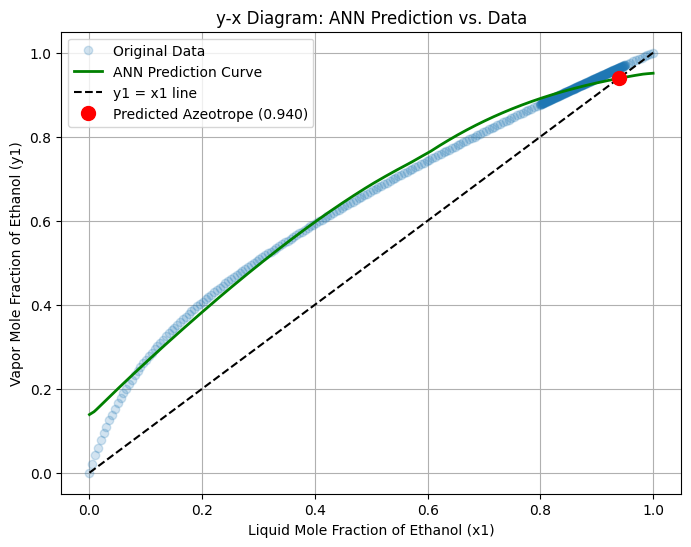


--- Final Comparison ---
ANN Predicted Azeotrope: x1=0.9399, T=79.62°C
Reference Literature Value: x1=0.894, T=78.2°C


In [ ]:
# --- 21. Final y-x diagram ---
plt.figure(figsize=(8, 6))
plt.plot(df['x1'], df['y1'], 'o', label='Original Data', alpha=0.2)
plt.plot(x1_range, y1_pred_range, color='green', linewidth=2, label='ANN Prediction Curve')
plt.plot([0, 1], [0, 1], 'k--', label='y1 = x1 line')
# Mark the detected azeotrope
plt.plot(azeotrope_x, azeotrope_x, 'ro', markersize=10, label=f'Predicted Azeotrope ({azeotrope_x:.3f})')
plt.title('y-x Diagram: ANN Prediction vs. Data')
plt.xlabel('Liquid Mole Fraction of Ethanol (x1)')
plt.ylabel('Vapor Mole Fraction of Ethanol (y1)')
plt.legend()
plt.grid(True)
plt.show()

# --- 22. Compare with reference data ---
print("\n--- Final Comparison ---")
print(f"ANN Predicted Azeotrope: x1={azeotrope_x:.4f}, T={azeotrope_T:.2f}°C")
print(f"Reference Literature Value: x1=0.894, T=78.2°C")